In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/208.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/333.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/45.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/369.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/56.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/89.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/20.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/275.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/212.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/239.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/58.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/150.jpg
/kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val/Pneumonia/6.jpg
/kaggle/input/lungx

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
# Main folder path
base_path = "/kaggle/input/lungxrays-grayscale/LungXRays-grayscale"

# Class names
class_names = ["Corona Virus Disease", "Normal", "Pneumonia", "Tuberculosis"]

# Dictionary to store the total number of images
class_counts = {class_name: {"train": 0, "val": 0, "test": 0} for class_name in class_names}

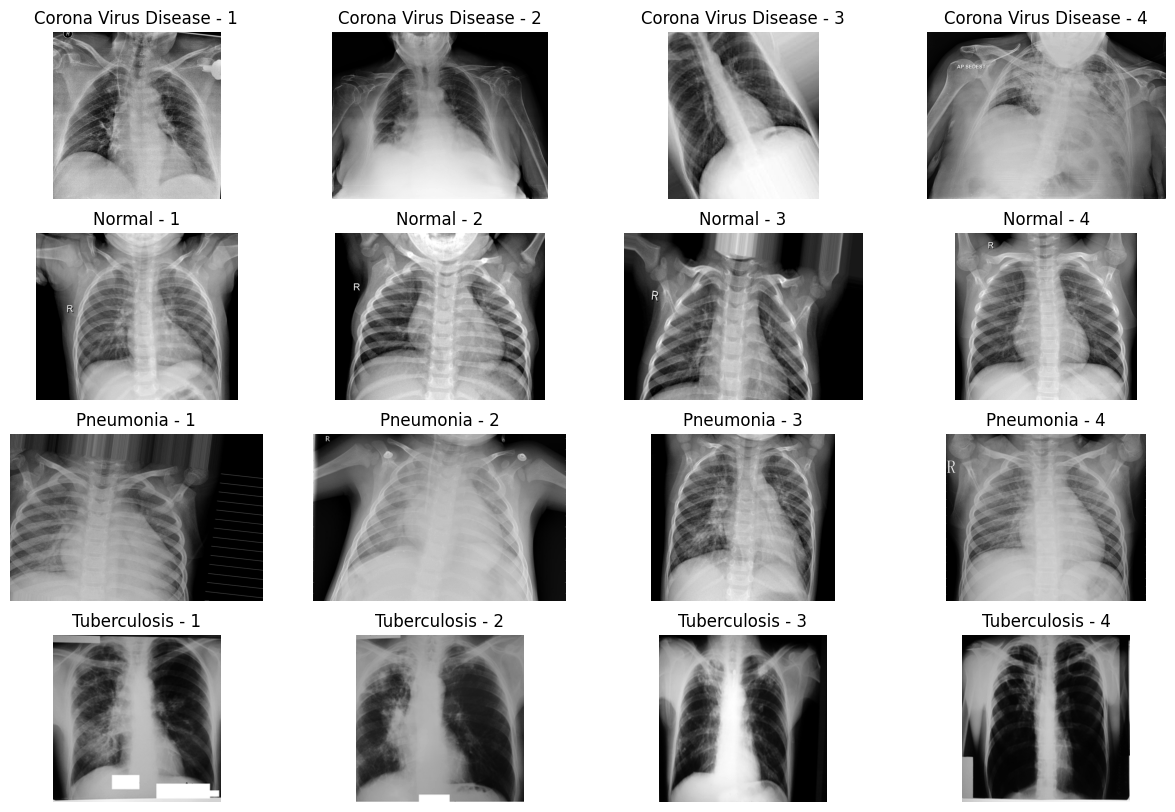

In [6]:
# Prepare subplots to show four images from each class
fig, axs = plt.subplots(len(class_names), 4, figsize=(15, 10))

# Iterate through each class
for i, class_name in enumerate(class_names):
    # Inner loop to show four images from each class
    for j in range(4):
        # Select the image
        subset_path = os.path.join(base_path, "train", class_name)
        img_name = os.listdir(subset_path)[j]
        img_path = os.path.join(subset_path, img_name)
        
        # Load and add the image to the subplot
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(f"{class_name} - {j+1}")
        axs[i, j].axis('off')  # Turn off axes

# Show the plot
plt.show()

In [7]:
train_path = os.path.join(base_path, "train")
print("train : ", train_path)

val_path = os.path.join(base_path, "val")
print("valid : ", val_path)

train :  /kaggle/input/lungxrays-grayscale/LungXRays-grayscale/train
valid :  /kaggle/input/lungxrays-grayscale/LungXRays-grayscale/val


In [8]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Model Parameters
img_height, img_width = 150, 150
batch_size = 32
num_classes = len(os.listdir(train_path))

# Data Augmentation & Normalization
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Data
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Corona Virus Disease', 'Normal', 'Pneumonia', 'Tuberculosis']


In [11]:
import torch.nn as nn
import torchvision.models as models

class BrainTumorModel(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorModel, self).__init__()

        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        self.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.backbone.features[-3:].parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorModel(4).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 119MB/s] 


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for 1 channel
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, device='cuda'):
    best_acc = 0.0
    patience_counter = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_wts)
                break

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, device=device)

Epoch 1/50, Train Loss: 0.3581, Train Acc: 86.50%, Val Loss: 0.2108, Val Acc: 92.22%
Epoch 2/50, Train Loss: 0.1773, Train Acc: 93.58%, Val Loss: 0.1570, Val Acc: 94.51%
Epoch 3/50, Train Loss: 0.1401, Train Acc: 95.02%, Val Loss: 0.2008, Val Acc: 93.02%
Epoch 4/50, Train Loss: 0.0963, Train Acc: 96.40%, Val Loss: 0.1584, Val Acc: 94.69%
Epoch 5/50, Train Loss: 0.0850, Train Acc: 96.67%, Val Loss: 0.1587, Val Acc: 93.95%
Epoch 6/50, Train Loss: 0.0653, Train Acc: 97.78%, Val Loss: 0.1831, Val Acc: 94.38%
Epoch 7/50, Train Loss: 0.0745, Train Acc: 97.39%, Val Loss: 0.2717, Val Acc: 90.80%
Epoch 8/50, Train Loss: 0.0609, Train Acc: 97.80%, Val Loss: 0.2746, Val Acc: 92.10%
Epoch 9/50, Train Loss: 0.0445, Train Acc: 98.31%, Val Loss: 0.2662, Val Acc: 93.77%
Early stopping triggered.


In [16]:
# Load the trained model
torch.save(model.state_dict(), "final_model.pth")
print("Final trained model saved as final_model.pth")

Final trained model saved as final_model.pth


In [19]:
# Load the trained model
model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")


Model loaded successfully.


<ipython-input-19-94cc044959f1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))


<ipython-input-22-8874e0ca3383>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))  # Load best model



Classification Report:
                      precision    recall  f1-score   support

Corona Virus Disease       0.97      0.97      0.97       406
              Normal       0.98      0.81      0.89       402
           Pneumonia       0.85      0.98      0.91       406
        Tuberculosis       0.96      1.00      0.98       406

            accuracy                           0.94      1620
           macro avg       0.94      0.94      0.94      1620
        weighted avg       0.94      0.94      0.94      1620



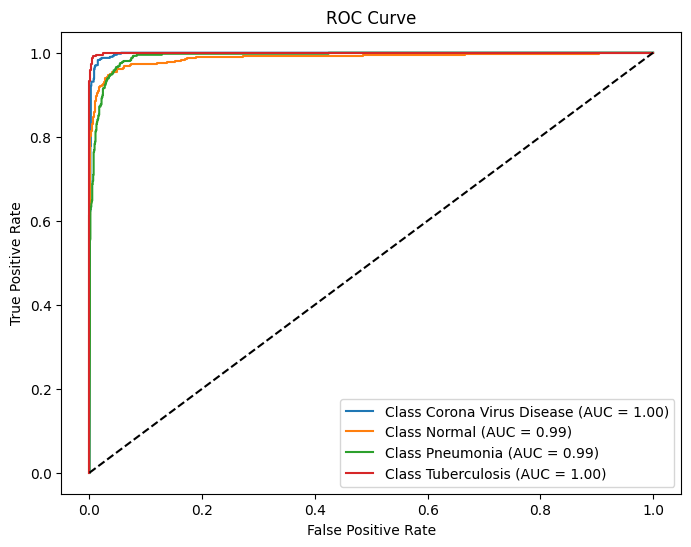

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations (Same as training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for 1 channel
])


# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorModel(num_classes=len(val_dataset.classes)).to(device)  # Ensure correct number of classes
model.load_state_dict(torch.load("/kaggle/working/final_model.pth"))  # Load best model
model.eval()  # Set to evaluation mode

# Evaluation
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Softmax for ROC

# **Classification Report**
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# **ROC Curve & AUC Score**
all_labels_bin = label_binarize(all_labels, classes=list(range(len(val_dataset.classes))))
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(8, 6))
for i in range(len(val_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_probs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {val_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize for 1 channel
])

# Define dataset paths
train_path = "path_to_train_data"
val_path = "path_to_validation_data"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, device='cuda'):
    best_acc = 0.0
    patience_counter = 0
    
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")  # Progress bar
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix(loss=running_loss/len(train_loader), acc=100. * correct / total)  # Update progress bar
        
        train_acc = 100. * correct / total
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_wts)
                break

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, device=device)
